In [1]:
%pylab inline

import os
import styles.paper
from scipy.interpolate import interp1d as linear
from scipy.misc import derivative

Populating the interactive namespace from numpy and matplotlib


In [2]:
idir = os.path.expandvars("$master/notebooks/data/G05Indexes/stelib")
odir = os.path.expandvars("$HOME/Documents/Publications/photofit_near_paper")

ax_xlabel = {
    "age": r"\bf \log{t/\text{yr}}"
}
ax_ylabels = {
    "D4000": r"\bf D$4000$",
    "Hbeta": r"\bf H$\beta$",
    "Hdg": r"\bf H$\delta_A$+H$\gamma_A$",
    "Mg2Fe": r"\bf [Mg${}_2$Fe]",
    "MgFep": r"\bf [MgFe]'",
    "u-g": r"\bf $u-g$",
    "g-r": r"\bf $g-r$",
    "g-i": r"\bf $g-i$",
    "g-z": r"\bf $g-z$",
    "M/L_u": r"\bf $M_\star/L_u$",
    "M/L_g": r"\bf $M_\star/L_g$",
    "M/L_r": r"\bf $M_\star/L_r$",
    "M/L_i": r"\bf $M_\star/L_i$",
    "M/L_z": r"\bf $M_\star/L_z$"
}
libraries = {
    "stelib": {
        "m32": r"0.0004",
        "m42": r"0.004",
        "m52": r"0.008",
        "m62": r"0.02",
        "m72": r"0.05"
    },
    "miles": {
        "z001": r"0.001",
        "z004": r"0.004",
        "z008": r"0.008",
        "z017": r"0.017",
        "z030": r"0.03",
        "z040": r"0.04"
    }
}

file_maps = {
    "tau0": {
        "6lsindx_sed": {
            "age": 0,
            "Mg2": 12,
            "Hbeta": 9,
            "Fe4531": 7,
            "Fe5015": 10,
            "Mgb": 13,
        },
        "7lsindx_sed": {
            "Fe5270": 1,
            "Fe5335": 2,
            "Hdelta_A": 9,
            "Hgamma_A": 10,
            "D4000": 13
        },
        "1ABmag": {
            "u-g": 3,
            "g-r": 4,
            "g-i": 5,
            "g-z": 6,
            "L_u": ((2,3), lambda mags: 10**(-0.4*((mags[:,0]+mags[:,1])-5.46))),
            "L_g": (2, lambda mag: 10**(-0.4*(mag-5.21))),
            "L_r": ((2,4), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-4.50))),
            "L_i": ((2,5), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-4.16))),
            "L_z": ((2,6), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-3.99)))
        },
        "4color": {
            "M": 10
        }
    },
    "tau2": {
        "w_age": {
            "age": (5, log10)
        },
        "6lsindx_sed": {
            "Mg2": 12,
            "Hbeta": 9,
            "Fe4531": 7,
            "Fe5015": 10,
            "Mgb": 13,
        },
        "7lsindx_sed": {
            "Fe5270": 1,
            "Fe5335": 2,
            "Hdelta_A": 9,
            "Hgamma_A": 10,
            "D4000": 13
        },
        "1ABmag": {
            "u-g": 3,
            "g-r": 4,
            "g-i": 5,
            "g-z": 6,
            "L_u": ((2,3), lambda mags: 10**(-0.4*((mags[:,0]+mags[:,1])-5.46))),
            "L_g": (2, lambda mag: 10**(-0.4*(mag-5.21))),
            "L_r": ((2,4), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-4.50))),
            "L_i": ((2,5), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-4.16))),
            "L_z": ((2,6), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-3.99)))
        },
        "4color": {
            "M": 10
        }
    },
    "tau5": {
        "w_age": {
            "age": (5, log10)
        },
        "6lsindx_sed": {
            "Mg2": 12,
            "Hbeta": 9,
            "Fe4531": 7,
            "Fe5015": 10,
            "Mgb": 13,
        },
        "7lsindx_sed": {
            "Fe5270": 1,
            "Fe5335": 2,
            "Hdelta_A": 9,
            "Hgamma_A": 10,
            "D4000": 13
        },
        "1ABmag": {
            "u-g": 3,
            "g-r": 4,
            "g-i": 5,
            "g-z": 6,
            "L_u": ((2,3), lambda mags: 10**(-0.4*((mags[:,0]+mags[:,1])-5.46))),
            "L_g": (2, lambda mag: 10**(-0.4*(mag-5.21))),
            "L_r": ((2,4), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-4.50))),
            "L_i": ((2,5), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-4.16))),
            "L_z": ((2,6), lambda mags: 10**(-0.4*((mags[:,0]-mags[:,1])-3.99)))
        },
        "4color": {
            "M": 10
        }
    }
}

Mg2Fe = lambda Mg2, Fe4531, Fe5015: 0.6*Mg2 + 0.4*log10(abs(Fe4531+Fe5015))
MgFep = lambda Mgb, Fe5270, Fe5335: sqrt(abs(Mgb*(0.72*Fe5270+0.28*Fe5335)))
Hdg = lambda Hdelta, Hgamma: Hdelta + Hgamma
MLum = lambda M, L: M/L

def walk_map(library, model):
    return {
        zkw: {
            field: loadtxt("{}/{}_{}.{}".format(idir,model,zkw,ftype), usecols=(icol,)) if not hasattr(icol,"__getitem__") else icol[1](loadtxt("{}/{}_{}.{}".format(idir,model,zkw,ftype), usecols=((icol[0],) if not hasattr(icol[0],"__getitem__") else icol[0]))) for ftype in file_maps[model] for field, icol in file_maps[model][ftype].iteritems()
        } for zkw in libraries[library]
    }

def add_ingredient(stores, ingredients_list, directions, ingredient_name):
    for store in stores.values():
        store[ingredient_name] = directions(*tuple(store[ingredient] for ingredient in ingredients_list))
    return None

tau0_stelib = walk_map("stelib", "tau0")
tau2_stelib = walk_map("stelib", "tau2")
tau5_stelib = walk_map("stelib", "tau5")

add_ingredient(tau0_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau0_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau0_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau0_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau0_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau0_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau0_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau0_stelib, ("M", "L_z"), MLum, "M/L_z")

add_ingredient(tau2_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau2_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau2_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau2_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau2_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau2_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau2_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau2_stelib, ("M", "L_z"), MLum, "M/L_z")

add_ingredient(tau5_stelib, ("Mg2","Fe4531","Fe5015"), Mg2Fe, "Mg2Fe")
add_ingredient(tau5_stelib, ("Mgb","Fe5270","Fe5335"), MgFep, "MgFep")
add_ingredient(tau5_stelib, ("Hdelta_A","Hgamma_A"), Hdg, "Hdg")
add_ingredient(tau5_stelib, ("M", "L_u"), MLum, "M/L_u")
add_ingredient(tau5_stelib, ("M", "L_g"), MLum, "M/L_g")
add_ingredient(tau5_stelib, ("M", "L_r"), MLum, "M/L_r")
add_ingredient(tau5_stelib, ("M", "L_i"), MLum, "M/L_i")
add_ingredient(tau5_stelib, ("M", "L_z"), MLum, "M/L_z")

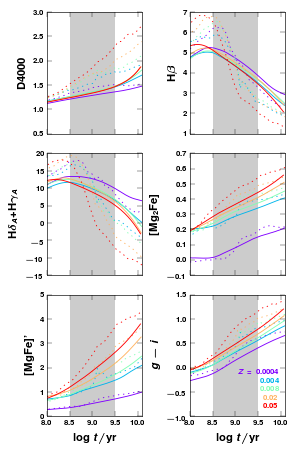

In [3]:
colors = cm.rainbow(linspace(0,1,len(libraries["stelib"])))
properties = ["D4000", "Hbeta", "Hdg", "Mg2Fe", "MgFep", "g-i"]

fig, axs = subplots(3, 2, sharex=True, figsize=(3.3,5))
xlim(8.0,10.1)

axs = axs.ravel()
for i in xrange(axs.size):
    prop = properties[i]
    
    axs[i].set_ylabel(ax_ylabels[prop])
    if axs[i].is_last_row(): axs[i].set_xlabel(ax_xlabel["age"])
    
    for j, zkw in enumerate(sorted(libraries["stelib"])):
        axs[i].plot(tau0_stelib[zkw]["age"], tau0_stelib[zkw][prop], ":", lw=0.7, color=colors[j])
        axs[i].plot(tau5_stelib[zkw]["age"], tau5_stelib[zkw][prop], "-", lw=0.7, color=colors[j])
        axs[i].axvspan(8.5, 9.5, lw=0, fc="none", hatch=15*"/", color="0.8")
        if i==5:
            axs[i].text(0.93, 0.35-j*0.07, (r"$Z={}$" if j==0 else r"${}$").format(libraries["stelib"][zkw]), color=colors[j], fontsize="x-small", ha="right", transform=axs[i].transAxes)

fig.tight_layout()
fig.subplots_adjust(wspace=0.5)

fig.savefig("{}/g05_indexes".format(odir))

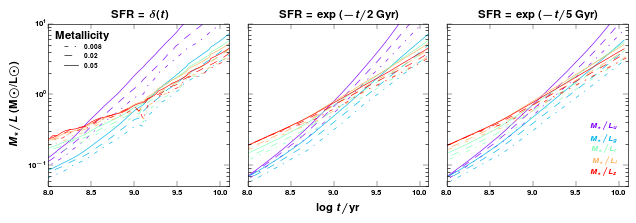

In [4]:
fig, axs = subplots(1, 3, sharey=True, sharex=True, figsize=(7,2.5))
xlim(8.0, 10.1)
ylim(5e-2, 1e1)
axs[0].set_ylabel(r"\bf $M_\star/L$ (M$\odot$/L$\odot$)")
axs[1].set_xlabel(ax_xlabel["age"])

properties = ["M/L_u", "M/L_g", "M/L_r", "M/L_i", "M/L_z"]
linestyles = ["-.", "--", "-"]
colors = cm.rainbow(linspace(0,1,len(properties)))
titles = [r"\bf $\text{SFR}=\delta(t)$", r"\bf $\text{SFR}=\exp{(-t/2\,\text{Gyr})}$", r"\bf $\text{SFR}=\exp{(-t/5\,\text{Gyr})}$"]

mlr = [tau0_stelib, tau2_stelib, tau5_stelib]
for i in xrange(axs.size):
    axs[i].set_title(titles[i])

    for k, prop in enumerate(properties):
        for j, zkw in enumerate(sorted(libraries["stelib"])[2:]):
            axs[i].semilogy(mlr[i][zkw]["age"], mlr[i][zkw][prop], linestyles[j], color=colors[k], lw=0.5, label=r"\bf ${}$".format(libraries["stelib"][zkw]))
        
        if i==0 and k==0:
            for line in axs[i].legend(loc=0, title=r"\bf Metallicity").get_lines(): line.set_color("k")
        if i==2:
            axs[i].text(0.93, 0.35-k*0.07, ax_ylabels[prop], color=colors[k], fontsize="x-small", ha="right", transform=axs[i].transAxes)
        
fig.tight_layout() 
fig.savefig("{}/mass-to-light".format("./img"))

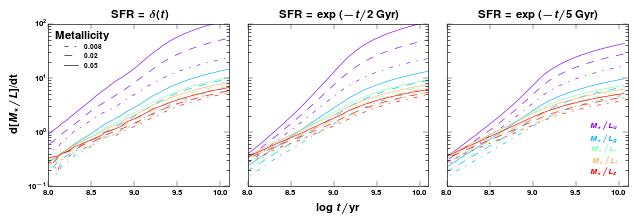

In [5]:
fig, axs = subplots(1, 3, sharey=True, sharex=True, figsize=(7,2.5))
xlim(8.0, 10.1)
ylim(1e-1, 1e2)
axs[0].set_ylabel(r"\bf $\text{d}[M_\star/L$]/\text{d}t")
axs[1].set_xlabel(ax_xlabel["age"])

properties = ["M/L_u", "M/L_g", "M/L_r", "M/L_i", "M/L_z"]
linestyles = ["-.", "--", "-"]
colors = cm.rainbow(linspace(0,1,len(properties)))
titles = [r"\bf $\text{SFR}=\delta(t)$", r"\bf $\text{SFR}=\exp{(-t/2\,\text{Gyr})}$", r"\bf $\text{SFR}=\exp{(-t/5\,\text{Gyr})}$"]

mlr = [tau0_stelib, tau2_stelib, tau5_stelib]
for i in xrange(axs.size):
    axs[i].set_title(titles[i])

    for k, prop in enumerate(properties):
        for j, zkw in enumerate(sorted(libraries["stelib"])[2:]):
            f = linear(mlr[i][zkw]["age"], mlr[i][zkw][prop], bounds_error=False, fill_value="extrapolate")
            x = mlr[i][zkw]["age"]
            y = array([derivative(f, x[n]) for n in xrange(x.size)])
            axs[i].semilogy(x, y, linestyles[j], color=colors[k], lw=0.5, label=r"\bf ${}$".format(libraries["stelib"][zkw]))
        
        if i==0 and k==0:
            for line in axs[i].legend(loc=0, title=r"\bf Metallicity").get_lines(): line.set_color("k")
        if i==2:
            axs[i].text(0.93, 0.35-k*0.07, ax_ylabels[prop], color=colors[k], fontsize="x-small", ha="right", transform=axs[i].transAxes)
        
fig.tight_layout() 
fig.savefig("{}/diff-mass-to-light".format("./img"))

In [6]:
#Si la forma del espectro no cambia en el tiempo, las curvas M/L(t) son paralelas entre una banda y otra.
#Mostrar 3 puntos a masa constante. Deberian coincidir en M/L y edad para poblaciones viejas.
#Mostrar la evolución de un modelo tau de la siguiente manera:
# - separar los espectros de las poblaciones más viejas y más jóvenes que 1Gaño
# - mostrar los espectros de las dos poblaciones en colores diferentes y la suma de ambos en negro
# - mostrar la edad pesada por la masa y la pesada por el flujo
# - mostrar la SSP que se corresponda con la edad pesada por la masa
#
#Lo que espero que pase es que las dos poblaciones evolucionarán a lo largo del tiempo de manera diferente.
#El espectro de la población vieja subyacente cambiará muy poco su forma a lo largo de la historia, solo el
#nivel de flujo cambiará.
#El espectro de la población que domina la luz integrada cambiará su forma y nivel de flujo constantemente.